## Whole Genome Sequenced Mycobacterium bovis analysis for BTBgenie.

Note: the current version of the M.bovis genome online has genes missing in the annotation. See https://www.ncbi.nlm.nih.gov/nuccore/LT708304.1?report=graph

Updated files can be found here: https://github.com/dmnfarrell/gordon-group/tree/master/mbovis_annotation

links:

* https://github.com/JosephCrispell/GeneralTools/tree/master/ProcessingPipeline
* http://www.htslib.org/doc/bcftools.html
* https://mtbgenomicsworkshop.readthedocs.io/
* [BCFtools cheat sheet](https://gist.github.com/elowy01/93922762e131d7abd3c7e8e166a74a0b)
* https://pypi.org/project/pyfaidx/

In [179]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
import pylab as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from gzip import open as gzopen
sys.path.append('pathogenie')
from pathogenie import tools, aligners, app

### Examine FASTQ file quality and define trimming parameters

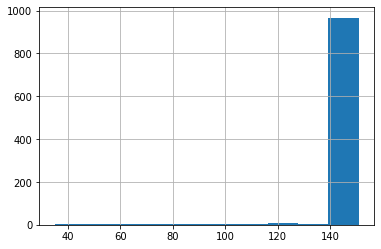

In [335]:
reload(tools)
testfile='albania/3_S57_L001-4_R1_001.fastq.gz'
testfile='WT_S18_L001-4_R1_001.fastq.gz'
df = tools.fastq_to_dataframe(testfile)
df.length.hist()

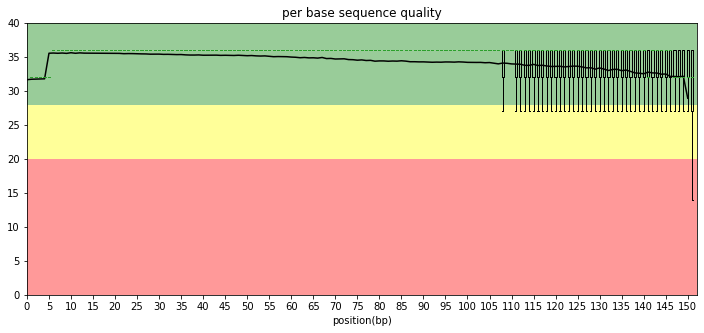

In [377]:
def plot_fastq_qualities(filename, ax=None, limit=10000):
    
    import matplotlib.patches as patches
    fastq_parser = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    res=[]
    c=0
    for record in fastq_parser:
        score=record.letter_annotations["phred_quality"]
        res.append(score)
        c+=1
        if c>limit:
            break
    df = pd.DataFrame(res)
    l = len(df.T)+1
    
    if ax==None:
        f,ax=plt.subplots(figsize=(12,5))
    rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
    ax.add_patch(rect)
    rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
    ax.add_patch(rect)
    rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
    ax.add_patch(rect)
    df.mean().plot(ax=ax,c='black')
    boxprops = dict(linestyle='-', linewidth=1, color='black')
    df.plot(kind='box', ax=ax, grid=False, showfliers=False,
            color=dict(boxes='black',whiskers='black')  )
    ax.set_xticks(np.arange(0, l, 5))
    ax.set_xticklabels(np.arange(0, l, 5))
    ax.set_xlabel('position(bp)')
    ax.set_xlim((0,l))
    ax.set_ylim((0,40))
    ax.set_title('per base sequence quality')    
    return 

plot_fastq_qualities(testfile,limit=100000)
plt.savefig('fastq_quals.png',dpi=100)

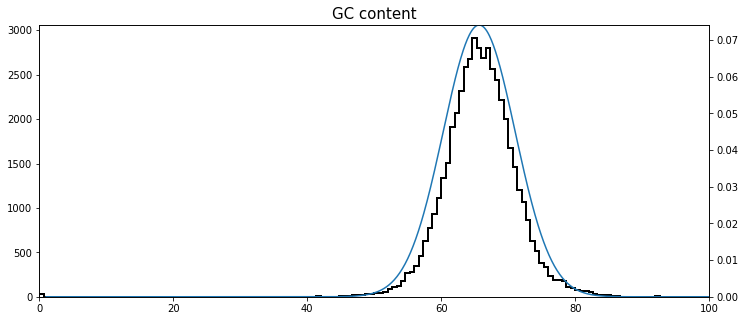

In [378]:
def normpdf(x, mean, sd):
    import math
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

def plot_fastq_gc_content(filename, ax=None, limit=50000):

    from Bio.SeqUtils import GC
    if ax==None:
        f,ax=plt.subplots(figsize=(12,5))
    df = tools.fastq_to_dataframe(filename, size=limit)
    gc = df.seq.apply(lambda x: GC(x))  
    gc.hist(ax=ax,bins=150,color='black',grid=False,histtype='step',lw=2)
    ax.set_xlim((0,100))    
    x=np.arange(1,100,.1)
    f = [normpdf(i, gc.mean(), gc.std()) for i in x]    
    ax2=ax.twinx()   
    ax2.plot(x,f)
    ax2.set_ylim(0,max(f))
    ax.set_title('GC content',size=15)
    return

plot_fastq_gc_content(testfile, limit=50000)
plt.savefig('gc.png',dpi=100)

In [254]:
reload(tools)
tools.trim_adapters(testfile, 'trimmed.fastq.gz')

cutadapt -O 5 -q 20 albania/3_S57_L001-4_R1_001.fastq.gz -o trimmed.fastq.gz


### Get sample ids from fastq files

In [75]:
path='albania'
files = glob.glob(os.path.join(path,'*.fastq.gz'))
print (files)
from collections import defaultdict

def get_sample_names(filenames):
    """Get sample pairs from list of fastq files."""

    res = []
    cols = ['name','sample','filename']
    for filename in filenames:
        name = os.path.basename(filename).split('.')[0]
        sample = name.split('_R')[0]
        x = [name, sample, filename]
        res.append(x)

    df = pd.DataFrame(res, columns=cols)    
    df['pair'] = df.groupby('sample').cumcount()+1
    df = df.sort_values(['name','sample','pair']).reset_index(drop=True)
    return df

df = get_sample_names(files)
df
#df.set_index(['sample','pair']).unstack()


['albania/6_S7_L001-4_R2_001.fastq.gz', 'albania/3_S57_L001-4_R1_001.fastq.gz', 'albania/6_S7_L001-4_R1_001.fastq.gz', 'albania/3_S57_L001-4_R2_001.fastq.gz']


,name,sample,filename,pair
0,3_S57_L001-4_R1_001,3_S57_L001-4,albania/3_S57_L001-4_R1_001.fastq.gz,1
1,3_S57_L001-4_R2_001,3_S57_L001-4,albania/3_S57_L001-4_R2_001.fastq.gz,2
2,6_S7_L001-4_R1_001,6_S7_L001-4,albania/6_S7_L001-4_R1_001.fastq.gz,2
3,6_S7_L001-4_R2_001,6_S7_L001-4,albania/6_S7_L001-4_R2_001.fastq.gz,1


### Align the FASTQ files against reference and create VCF files

In [76]:
reload(aligners)
path = 'albania'
ref = app.ref_genome

samples = get_sample_names(files)
def align_reads(samples, idx, outdir='mapped', callback=None, **kwargs):
    """
    Align multiple files. Requires a dataframe with a 'sample' column to indicate
    paired files grouping.
    """

    if not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)
    new = []
    for name,df in samples.groupby('sample'):
        print (name)
        files = list(df.filename)
        #print (files)
        out = os.path.join(outdir,name+'.bam')
        print (out)
        aligners.bwa_align(files[0],files[1], idx=idx, out=out, **kwargs)
        cmd = 'samtools index {o}'.format(o=out)
        subprocess.check_output(cmd,shell=True)
        index = df.index
        samples.loc[index,'bam_file'] = out        
        if callback != None:
            callback(out)
    return samples

align_reads(samples, idx=ref, threads=10, overwrite=True)

3_S57_L001-4
mapped/3_S57_L001-4.bam
bwa mem -M -t 10 /home/damien/gitprojects/btbgenie/pathogenie/pathogenie/data/Mbovis_AF212297.fa albania/3_S57_L001-4_R1_001.fastq.gz albania/3_S57_L001-4_R2_001.fastq.gz | samtools view -bt - | samtools sort -o mapped/3_S57_L001-4.bam
6_S7_L001-4
mapped/6_S7_L001-4.bam
bwa mem -M -t 10 /home/damien/gitprojects/btbgenie/pathogenie/pathogenie/data/Mbovis_AF212297.fa albania/6_S7_L001-4_R1_001.fastq.gz albania/6_S7_L001-4_R2_001.fastq.gz | samtools view -bt - | samtools sort -o mapped/6_S7_L001-4.bam


,name,sample,filename,pair,bam_file
0,3_S57_L001-4_R1_001,3_S57_L001-4,albania/3_S57_L001-4_R1_001.fastq.gz,1,mapped/3_S57_L001-4.bam
1,3_S57_L001-4_R2_001,3_S57_L001-4,albania/3_S57_L001-4_R2_001.fastq.gz,2,mapped/3_S57_L001-4.bam
2,6_S7_L001-4_R1_001,6_S7_L001-4,albania/6_S7_L001-4_R1_001.fastq.gz,2,mapped/6_S7_L001-4.bam
3,6_S7_L001-4_R2_001,6_S7_L001-4,albania/6_S7_L001-4_R2_001.fastq.gz,1,mapped/6_S7_L001-4.bam


### remove duplicated reads

In [ ]:
cmd = 'samtools rmdup A_reads.bt2.sorted.bam A_reads.bt2.sorted.noDups.bam'

### call all samples at once

In [77]:
def variant_calling(bam_files, ref, outpath, callback=None, **kwargs):
    """Call variants with bcftools"""

    rawbcf = os.path.join(outpath,'raw.bcf')
    cmd = 'bcftools mpileup -O b -o {o} -f {r} {b}'.format(r=ref, b=bam_files, o=rawbcf)
    print (cmd)
    if callback != None:
        callback(cmd)      
    subprocess.check_output(cmd,shell=True)
    #find snps
    vcfout = os.path.join(outpath,'calls.vcf')
    cmd = 'bcftools call --ploidy 1 -m -v -o {v} {raw}'.format(v=vcfout,raw=rawbcf)
    if callback != None:
        callback(cmd)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    #filter the calls
    vcfout = os.path.join(outpath,'calls.vcf')
    final = os.path.join(outpath,'filtered')
    cmd = 'vcftools --vcf {i} --minQ 20 --recode --recode-INFO-all --out {o}'.format(i=vcfout,o=final)
    print (cmd)
    tmp = subprocess.check_output(cmd,shell=True)
    if callback != None:
        callback(tmp)    
    return final

bam_files = ' '.join(glob.glob('mapped/*.bam'))
variant_calling(bam_files, ref, 'mapped')

bcftools mpileup -O b -o mapped/raw.bcf -f /home/damien/gitprojects/btbgenie/pathogenie/pathogenie/data/Mbovis_AF212297.fa mapped/3_S57_L001-4.bam mapped/6_S7_L001-4.bam
bcftools call --ploidy 1 -m -v -o mapped/calls.vcf mapped/raw.bcf
vcftools --vcf mapped/calls.vcf --minQ 20 --recode --recode-INFO-all --out mapped/filtered


In [ ]:
cmd = 'bcftools filter --vcf mapped/calls.vcf --minQ 20 --recode --recode-INFO-all'
print (cmd)
tmp = subprocess.check_output(cmd,shell=True)

### Consequence calling

In [ ]:
cmd = 'bcftools csq -f Mbovis_AF212297.fa -g  Mbovis_csq_format.gff col2_mbovis.vcf -Ot -o col2_mbovis.csq.tsv'

### Make fasta alignment from filtered VCF sites with multiple samples

https://github.com/JosephCrispell/GeneralTools/blob/master/ProcessingPipeline/CreateFastaWithReferenceFromFiltered_28-06-17.pl

In [ ]:
from pyfaidx import Fasta
from pyfaidx import FastaVariant
samples = ['mapped/3_S57_L001-4.bam','mapped/6_S7_L001-4.bam']
result=[]

#include reference
reference = Fasta(app.ref_genome)
chrom = list(reference.keys())[0]
variant = FastaVariant(app.ref_genome, 'mapped/calls.vcf.gz', 
                       sample= samples[0], het=True, hom=True)
refseq=[]
for var in variant[chrom].variant_sites:   
    refseq.append(reference[chrom][var].seq)
refseq = ''.join(refseq)
refvars = SeqRecord(Seq(refseq),id='ref')
result.append(refvars)

for sample in samples:
    variant = FastaVariant(app.ref_genome, 'mapped/calls.vcf.gz', 
                             sample=sample, het=True, hom=True)
    i=0
    seq = []
    #get ref first?
    for chrom in variant.keys():
        print (chrom, sample)
        print (len(variant[chrom].variant_sites))
        for var in variant[chrom].variant_sites:
            record = variant[chrom][var-1:var]
            print(var,record)
            seq.append(record.seq)
            #i+=1       
            #if i>100:
            #    break
        seq=''.join(seq)
        new = SeqRecord(Seq(seq),id=sample)
        result.append(new)
    print (seq)
    
SeqIO.write(result, 'variants.fa', 'fasta')

In [194]:
?reference[chrom][var]

Object `reference[chrom][var]` not found.


### Merge the VCF files together ??

In [ ]:
def merge_vcf():
    return

### Rescuing site information for poorer quality isolates

2121


### Phylogeny from MSA

In [110]:
from Bio.Phylo.Applications import RaxmlCommandline
raxml_cline = RaxmlCommandline(sequences="Tests/Phylip/interlaced2.phy",
                                model="PROTCATWAG", name="interlaced2")
print(raxml_cline)

raxmlHPC -m PROTCATWAG -n interlaced2 -p 10000 -s Tests/Phylip/interlaced2.phy
